Text(0, 0.5, 'Stock Price')

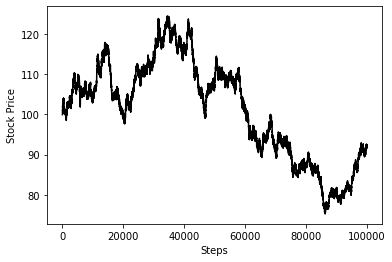

In [1]:
import matplotlib.pyplot as plt
import numpy as np

N=100000
sigma = 0.4
T = 0.5
K = 105
r= 0.05
dt = T / N
Heads = np.exp(sigma * np.sqrt(dt))
Tails = np.exp(-sigma * np.sqrt(dt))
S0 = 100
p = (  np.exp(r*dt) - Tails )  /  ( Heads - Tails )
paths = np.random.choice([Heads,Tails],p=[p,1-p],size=(N,1)) #隨機取出一個path
plt.plot(paths.cumprod(axis=0)*100, color='black'); #畫出這個path
plt.xlabel('Steps')
plt.ylabel('Stock Price')

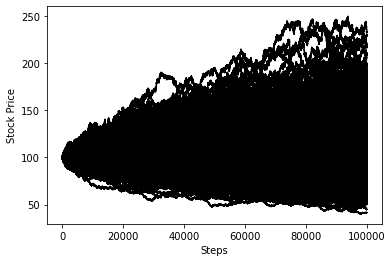

In [2]:
N=100000
sigma = 0.4
T = 0.5
K = 105
r= 0.05
dt = T / N
Heads = np.exp(sigma * np.sqrt(dt))
Tails = np.exp(-sigma * np.sqrt(dt))
S0 = 100
p = (  np.exp(r*dt) - Tails )  /  ( Heads - Tails )
for i in range(1000):
    paths = np.random.choice([Heads,Tails],p=[p,1-p],size=(N,1)) #隨機取出一個path
    plt.plot(paths.cumprod(axis=0)*100, color='black'); #畫出這個path
plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.show()

In [10]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime as dt
import math
import requests

import matplotlib.pyplot as plt


def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))



def binom_EU1(S0, K , T, r, sigma, N, type_ = 'call'):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (  np.exp(r*dt) - d )  /  (  u - d )
    value = 0 
    for i in range(N+1):
        node_prob = combos(N, i)*p**i*(1-p)**(N-i)
        ST = S0*(u)**i*(d)**(N-i)
        if type_ == 'call':
            value += max(ST-K,0) * node_prob
        elif type_ == 'put':
            value += max(K-ST, 0)*node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'" )
    
    return value*np.exp(-r*T)


def get_data(symbol):
   
    obj = web.YahooOptions(f'{symbol}')
    obj.headers = {'User-Agent': 'Chrome'}
    #response = requests.get(
    #"https://query1.finance.yahoo.com/v7/finance/options/TSLA", headers=headers).json()
    
    df = obj.get_all_data()

    df.reset_index(inplace=True)

    df['mid_price'] = (df.Ask+df.Bid) / 2
    df['Time'] = (df.Expiry - dt.datetime.now()).dt.days / 255
    
    return df[(df.Bid>0) & (df.Ask >0)]


df = get_data('TSLA')
print(df)

       Strike     Expiry  Type               Symbol     Last      Bid  \
0        1.67 2023-01-20  call  TSLA230120C00001670   137.11   121.00   
2        1.67 2023-03-17  call  TSLA230317C00001670   120.30   120.55   
4        1.67 2023-06-16  call  TSLA230616C00001670   120.30   121.10   
6        1.67 2023-09-15  call  TSLA230915C00001670   156.63   119.45   
7        1.67 2023-09-15   put  TSLA230915P00001670     0.01     0.01   
...       ...        ...   ...                  ...      ...      ...   
4568  2425.00 2024-01-19   put  TSLA240119P02425000  1671.40  1776.00   
4570  2450.00 2023-01-20   put  TSLA230120P02450000  1695.35  1750.05   
4574  2450.00 2023-06-16   put  TSLA230616P02450000  1664.23  1745.55   
4578  2475.00 2023-01-20   put  TSLA230120P02475000  1737.00  1556.45   
4582  2475.00 2023-06-16   put  TSLA230616P02475000  1770.00  1568.20   

          Ask       Chg     PctChg   Vol  ...        IV  Root IsNonstandard  \
0      121.90  0.000000   0.000000   1.0  ..

In [11]:
prices = [] 


for row in df.itertuples():
    price = binom_EU1(row.Underlying_Price, row.Strike, row.Time, 0.01, 0.5, 20, row.Type)
    prices.append(price)
print(price)

2335.11565324441


In [12]:
df.Expiry.unique()[2]

numpy.datetime64('2023-06-16T00:00:00.000000000')

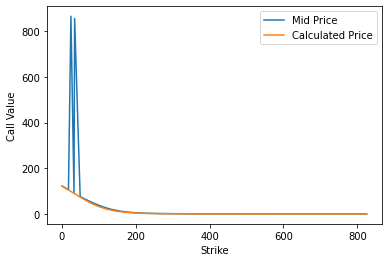

In [13]:


    
    
df['Price'] = prices
    
df['error'] = df.mid_price - df.Price 
    
#計算在 df.Expiry.unique()[2] 的 call price
exp1 = df[(df.Expiry == df.Expiry.unique()[2]) & (df.Type=='call')]


plt.plot(exp1.Strike, exp1.mid_price,label= 'Mid Price')
plt.plot(exp1.Strike, exp1.Price, label = 'Calculated Price')
plt.xlabel('Strike')
plt.ylabel('Call Value')
plt.legend()


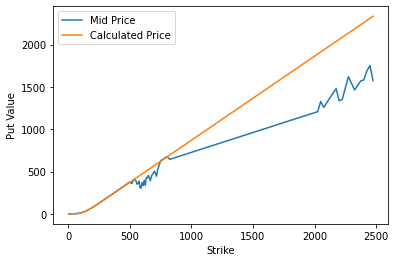

In [15]:
#計算在 df.Expiry.unique()[2] 的 put price
exp1 = df[(df.Expiry == df.Expiry.unique()[2]) & (df.Type=='put')]


plt.plot(exp1.Strike, exp1.mid_price,label= 'Mid Price')
plt.plot(exp1.Strike, exp1.Price, label = 'Calculated Price')
plt.xlabel('Strike')
plt.ylabel('Put Value')
plt.legend()